# Find Alpha Attribute from Sepsis dataset. clustering/classification

### Reading data

In [48]:
import os
import pm4py
from pm4py.objects.log.importer.xes import importer as xes_importer
import warnings
warnings.simplefilter("ignore")
from pm4py.objects.log.log import EventLog
# from ClusterFlags import bag_of_activities
from pm4py.objects.log.util import get_log_representation as get_
from sklearn.decomposition import PCA
from pm4py.objects.log.obj import EventLog, Trace
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
import numpy as np

### Filtered data = Complete traces - Ending in Release

In [49]:
import pandas as pd
sepsis = pd.read_csv('Datasets/Sepsis Cases - Event Log -Filtered.csv')
sepsis.head()

,Case ID,Activity,Complete Timestamp,Variant,Variant index,lifecycle:transition,org:group,InfectionSuspected,DiagnosticBlood,DisfuncOrg,...,SIRSCritLeucos,Oligurie,DiagnosticLacticAcid,Diagnose,Hypoxie,DiagnosticUrinarySediment,DiagnosticECG,Leucocytes,CRP,LacticAcid
0,A,ER Registration,2014-10-22 11:15:41.000,Variant 35,35,complete,A,True,True,True,...,False,False,True,A,False,True,True,NaN,NaN,NaN
1,A,Leucocytes,2014-10-22 11:27:00.000,Variant 35,35,complete,B,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.6,NaN,NaN
2,A,CRP,2014-10-22 11:27:00.000,Variant 35,35,complete,B,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21.0,NaN
3,A,LacticAcid,2014-10-22 11:27:00.000,Variant 35,35,complete,B,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.2
4,A,ER Triage,2014-10-22 11:33:37.000,Variant 35,35,complete,C,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Getting Release Type of every case

In [50]:
rel = sepsis[['Case ID', 'Activity']]
release = rel[rel['Activity'].str.contains('Release')]

### Counting number of activities

In [51]:
count_events = sepsis[['Case ID','Activity','Leucocytes', 'CRP', 'LacticAcid']]
count_events_and_tests= count_events.groupby('Case ID')[['Activity','Leucocytes', 'CRP', 'LacticAcid']].count()
count_events_and_tests.head()


,Activity,Leucocytes,CRP,LacticAcid
Case ID,,,,
A,22,7,7,1
AAA,11,1,1,1
ABA,17,5,4,1
AC,13,2,2,1
AD,29,7,7,5


### Dropping non important features.

In [52]:
sepsis = sepsis.drop(['Activity', 'Complete Timestamp', 'Variant', 'Variant index',
    'lifecycle:transition', 'org:group'], axis=1)
sepsis.head(20)

,Case ID,InfectionSuspected,DiagnosticBlood,DisfuncOrg,SIRSCritTachypnea,Hypotensie,SIRSCritHeartRate,Infusion,DiagnosticArtAstrup,Age,...,SIRSCritLeucos,Oligurie,DiagnosticLacticAcid,Diagnose,Hypoxie,DiagnosticUrinarySediment,DiagnosticECG,Leucocytes,CRP,LacticAcid
0,A,True,True,True,True,True,True,True,True,85.0,...,False,False,True,A,False,True,True,NaN,NaN,NaN
1,A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.6,NaN,NaN
2,A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21.0,NaN
3,A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.2
4,A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,109.0,NaN


### Dropping rows with NAN values i.e. keeping 1 row for each case

In [53]:
sep=sepsis.dropna(thresh=15)
sep.reset_index(drop=True, inplace=True)
sep.shape

(777, 28)

In [54]:
len(sepsis.Diagnose.unique())


142

In [55]:
count_events_and_tests =count_events_and_tests.reset_index()

In [56]:
# Renaming Column names of dataframe of Counts
count_events_and_tests.rename(columns={'Activity': 'Activity_count', 'Leucocytes': 'Leucocytes_count','CRP':'CRP_count','LacticAcid':'LacticAcid_count'}, inplace=True)
release.rename(columns={'Activity': 'Release_type'}, inplace=True)

### Dropping Tests from sepsis dataset

In [57]:
sep = sep.drop(['Leucocytes', 'CRP', 'LacticAcid'], axis=1)
sep.head()

,Case ID,InfectionSuspected,DiagnosticBlood,DisfuncOrg,SIRSCritTachypnea,Hypotensie,SIRSCritHeartRate,Infusion,DiagnosticArtAstrup,Age,...,DiagnosticXthorax,SIRSCritTemperature,DiagnosticUrinaryCulture,SIRSCritLeucos,Oligurie,DiagnosticLacticAcid,Diagnose,Hypoxie,DiagnosticUrinarySediment,DiagnosticECG
0,A,True,True,True,True,True,True,True,True,85.0,...,True,True,True,False,False,True,A,False,True,True
1,B,True,True,False,True,False,True,True,False,45.0,...,True,True,True,False,False,True,B,False,True,True
2,C,True,True,False,False,False,True,True,True,55.0,...,False,True,True,False,False,True,C,False,True,True
3,D,True,True,False,True,False,True,True,True,70.0,...,True,True,False,False,False,True,D,False,False,True
4,F,True,True,False,False,False,True,True,False,50.0,...,True,True,False,False,False,True,E,False,False,True


### Merging All dataframes to constitute table with additional columns i.e. Count of activities and Tests conducted

In [58]:
mer =pd.merge(count_events_and_tests, release, on='Case ID', how='outer')
mer.shape

(777, 6)

In [59]:
processed_data = pd.merge(sep, mer, on='Case ID', how='outer')
processed_data.head(10)

,Case ID,InfectionSuspected,DiagnosticBlood,DisfuncOrg,SIRSCritTachypnea,Hypotensie,SIRSCritHeartRate,Infusion,DiagnosticArtAstrup,Age,...,DiagnosticLacticAcid,Diagnose,Hypoxie,DiagnosticUrinarySediment,DiagnosticECG,Activity_count,Leucocytes_count,CRP_count,LacticAcid_count,Release_type
0,A,True,True,True,True,True,True,True,True,85.0,...,True,A,False,True,True,22.0,7.0,7.0,1.0,Release A
1,B,True,True,False,True,False,True,True,False,45.0,...,True,B,False,True,True,12.0,1.0,3.0,1.0,Release A
2,C,True,True,False,False,False,True,True,True,55.0,...,True,C,False,True,True,14.0,3.0,3.0,0.0,Release A
3,D,True,True,False,True,False,True,True,True,70.0,...,True,D,False,False,True,13.0,2.0,2.0,1.0,Release A
4,F,True,True,False,False,False,True,True,False,50.0,...,True,E,False,False,True,10.0,1.0,1.0,1.0,Release A
5,G,True,True,False,False,False,True,True,False,60.0,...,True,F,False,True,True,12.0,2.0,2.0,1.0,Release A
6,H,False,False,False,True,False,True,False,False,80.0,...,False,G,False,False,False,13.0,2.0,3.0,1.0,Release B
7,I,True,True,False,False,False,True,False,True,80.0,...,True,H,False,True,True,11.0,2.0,2.0,1.0,Release A
8,J,True,True,False,True,False,True,True,False,80.0,...,True,B,False,True,True,11.0,1.0,2.0,1.0,Release A
9,K,True,True,False,True,False,True,True,False,50.0,...,True,I,False,True,True,16.0,3.0,3.0,1.0,Release A


### Data Cleaning

In [60]:
processed_data.isna().sum()

Case ID                       1
InfectionSuspected            0
DiagnosticBlood               0
DisfuncOrg                    0
SIRSCritTachypnea             0
Hypotensie                    0
SIRSCritHeartRate             0
Infusion                      0
DiagnosticArtAstrup           0
Age                          43
DiagnosticIC                  0
DiagnosticSputum              0
DiagnosticLiquor              0
DiagnosticOther               0
SIRSCriteria2OrMore           0
DiagnosticXthorax             0
SIRSCritTemperature           0
DiagnosticUrinaryCulture      0
SIRSCritLeucos                0
Oligurie                      0
DiagnosticLacticAcid          0
Diagnose                     47
Hypoxie                       0
DiagnosticUrinarySediment     0
DiagnosticECG                 0
Activity_count                1
Leucocytes_count              1
CRP_count                     1
LacticAcid_count              1
Release_type                  0
dtype: int64

In [61]:
# Deleting Case with null case id, Dropping rows with Age and Diagnosis null.
df = processed_data[processed_data['Case ID'].notna()]
df = df[df['Diagnose'].notna()]

In [62]:
df.isna().sum()

Case ID                      0
InfectionSuspected           0
DiagnosticBlood              0
DisfuncOrg                   0
SIRSCritTachypnea            0
Hypotensie                   0
SIRSCritHeartRate            0
Infusion                     0
DiagnosticArtAstrup          0
Age                          0
DiagnosticIC                 0
DiagnosticSputum             0
DiagnosticLiquor             0
DiagnosticOther              0
SIRSCriteria2OrMore          0
DiagnosticXthorax            0
SIRSCritTemperature          0
DiagnosticUrinaryCulture     0
SIRSCritLeucos               0
Oligurie                     0
DiagnosticLacticAcid         0
Diagnose                     0
Hypoxie                      0
DiagnosticUrinarySediment    0
DiagnosticECG                0
Activity_count               0
Leucocytes_count             0
CRP_count                    0
LacticAcid_count             0
Release_type                 0
dtype: int64

In [63]:
df.head()

,Case ID,InfectionSuspected,DiagnosticBlood,DisfuncOrg,SIRSCritTachypnea,Hypotensie,SIRSCritHeartRate,Infusion,DiagnosticArtAstrup,Age,...,DiagnosticLacticAcid,Diagnose,Hypoxie,DiagnosticUrinarySediment,DiagnosticECG,Activity_count,Leucocytes_count,CRP_count,LacticAcid_count,Release_type
0,A,True,True,True,True,True,True,True,True,85.0,...,True,A,False,True,True,22.0,7.0,7.0,1.0,Release A
1,B,True,True,False,True,False,True,True,False,45.0,...,True,B,False,True,True,12.0,1.0,3.0,1.0,Release A
2,C,True,True,False,False,False,True,True,True,55.0,...,True,C,False,True,True,14.0,3.0,3.0,0.0,Release A
3,D,True,True,False,True,False,True,True,True,70.0,...,True,D,False,False,True,13.0,2.0,2.0,1.0,Release A
4,F,True,True,False,False,False,True,True,False,50.0,...,True,E,False,False,True,10.0,1.0,1.0,1.0,Release A


In [64]:
print(df.describe())

              Age  Activity_count  Leucocytes_count   CRP_count  \
count  729.000000      729.000000        729.000000  729.000000   
mean    71.995885       16.954733          3.855967    3.639232   
std     15.525192       12.009240          4.717264    4.218959   
min     20.000000        5.000000          0.000000    0.000000   
25%     65.000000       12.000000          2.000000    2.000000   
50%     75.000000       14.000000          3.000000    3.000000   
75%     85.000000       18.000000          4.000000    4.000000   
max     90.000000      185.000000         74.000000   69.000000   

       LacticAcid_count  
count        729.000000  
mean           1.625514  
std            3.099266  
min            0.000000  
25%            1.000000  
50%            1.000000  
75%            1.000000  
max           51.000000  


In [65]:
# Converting True and False in to 1 and 0
df.replace({False: 0, True: 1}, inplace=True)
df.head()

,Case ID,InfectionSuspected,DiagnosticBlood,DisfuncOrg,SIRSCritTachypnea,Hypotensie,SIRSCritHeartRate,Infusion,DiagnosticArtAstrup,Age,...,DiagnosticLacticAcid,Diagnose,Hypoxie,DiagnosticUrinarySediment,DiagnosticECG,Activity_count,Leucocytes_count,CRP_count,LacticAcid_count,Release_type
0,A,1,1,1,1,1,1,1,1,85.0,...,1,A,0,1,1,22.0,7.0,7.0,1.0,Release A
1,B,1,1,0,1,0,1,1,0,45.0,...,1,B,0,1,1,12.0,1.0,3.0,1.0,Release A
2,C,1,1,0,0,0,1,1,1,55.0,...,1,C,0,1,1,14.0,3.0,3.0,0.0,Release A
3,D,1,1,0,1,0,1,1,1,70.0,...,1,D,0,0,1,13.0,2.0,2.0,1.0,Release A
4,F,1,1,0,0,0,1,1,0,50.0,...,1,E,0,0,1,10.0,1.0,1.0,1.0,Release A


In [66]:
df.select_dtypes(include=['object'])

,Case ID,Diagnose,Release_type
0,A,A,Release A
1,B,B,Release A
2,C,C,Release A
3,D,D,Release A
4,F,E,Release A
...,...,...,...
772,BNA,Z,Release A
773,CNA,BA,Release A
774,GNA,G,Release A
775,HNA,G,Release A


In [67]:
# Encoding Diagnose and Release Type categorical features
df[['Diagnose', 'Release_type']] = df[['Diagnose', 'Release_type']].apply(lambda x: pd.factorize(x)[0])
df.head()

,Case ID,InfectionSuspected,DiagnosticBlood,DisfuncOrg,SIRSCritTachypnea,Hypotensie,SIRSCritHeartRate,Infusion,DiagnosticArtAstrup,Age,...,DiagnosticLacticAcid,Diagnose,Hypoxie,DiagnosticUrinarySediment,DiagnosticECG,Activity_count,Leucocytes_count,CRP_count,LacticAcid_count,Release_type
0,A,1,1,1,1,1,1,1,1,85.0,...,1,0,0,1,1,22.0,7.0,7.0,1.0,0
1,B,1,1,0,1,0,1,1,0,45.0,...,1,1,0,1,1,12.0,1.0,3.0,1.0,0
2,C,1,1,0,0,0,1,1,1,55.0,...,1,2,0,1,1,14.0,3.0,3.0,0.0,0
3,D,1,1,0,1,0,1,1,1,70.0,...,1,3,0,0,1,13.0,2.0,2.0,1.0,0
4,F,1,1,0,0,0,1,1,0,50.0,...,1,4,0,0,1,10.0,1.0,1.0,1.0,0


In [68]:
df.shape

(729, 30)

In [69]:
df.to_csv('Datasets/Processed_cleaned_data.csv')

# Clustering 

## Clustering on Descriptive Features

In [70]:
df = pd.read_csv('Datasets/Processed_cleaned_data.csv')
df.shape

(729, 31)

In [71]:
descriptive_features = df.drop(['Case ID'],axis=1)
descriptive_features.head()

,Unnamed: 0,InfectionSuspected,DiagnosticBlood,DisfuncOrg,SIRSCritTachypnea,Hypotensie,SIRSCritHeartRate,Infusion,DiagnosticArtAstrup,Age,...,DiagnosticLacticAcid,Diagnose,Hypoxie,DiagnosticUrinarySediment,DiagnosticECG,Activity_count,Leucocytes_count,CRP_count,LacticAcid_count,Release_type
0,0,1,1,1,1,1,1,1,1,85.0,...,1,0,0,1,1,22.0,7.0,7.0,1.0,0
1,1,1,1,0,1,0,1,1,0,45.0,...,1,1,0,1,1,12.0,1.0,3.0,1.0,0
2,2,1,1,0,0,0,1,1,1,55.0,...,1,2,0,1,1,14.0,3.0,3.0,0.0,0
3,3,1,1,0,1,0,1,1,1,70.0,...,1,3,0,0,1,13.0,2.0,2.0,1.0,0
4,4,1,1,0,0,0,1,1,0,50.0,...,1,4,0,0,1,10.0,1.0,1.0,1.0,0


##  Elbow Method to extract optimal number of clusters

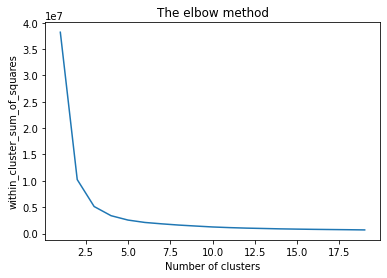

In [72]:

from sklearn.cluster import KMeans
within_cluster_sum_of_squares = []

for i in range(1, 20):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 42)
    kmeans.fit(descriptive_features)
    within_cluster_sum_of_squares.append(kmeans.inertia_)
    
#Plotting the results onto a line graph, allowing us to observe 'The elbow'
plt.plot(range(1, 20), within_cluster_sum_of_squares)
plt.title('The elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('within_cluster_sum_of_squares') #within cluster sum of squares
plt.show()

## Keeping filtered cases in the main event log

In [73]:

el = pd.read_csv('Datasets/Sepsis Cases - Event Log.csv')
cases = df['Case ID']
el = el.loc[el['Case ID'].isin(cases)] 
el.shape

(12360, 34)

In [74]:

dataframe = pm4py.format_dataframe(el, case_id='Case ID', activity_key='Activity', timestamp_key='Complete Timestamp')
event_log = pm4py.convert_to_event_log(dataframe)

k means Clustering

In [75]:

kmeans = KMeans(
        init="random",
        n_clusters=3,
        n_init=10,
        max_iter=300,
        random_state=42
    )
km = kmeans.fit(descriptive_features)




In [76]:
already_seen = {}
labels = km.labels_
clusters = []

for i in range(len(event_log)):
        if not labels[i] in already_seen:
            already_seen[labels[i]] = len(list(already_seen.keys()))
            clusters.append(EventLog())
        trace = event_log[i]
        clusters[already_seen[labels[i]]].append(trace)

type(clusters[0]),len(clusters[0]),len(clusters[1]),len(clusters[2])

(pm4py.objects.log.obj.EventLog, 234, 236, 259)

In [77]:
sub_log1 = clusters[0]
sub_log2 = clusters[1]
sub_log3 = clusters[2]

pm4py.write_xes(sub_log1, 'Sublogs-Alpha-Clustering/sublog1.xes')
pm4py.write_xes(sub_log2, 'Sublogs-Alpha-Clustering/sublog2.xes')
pm4py.write_xes(sub_log3, 'Sublogs-Alpha-Clustering/sublog3.xes')


exporting log, completed traces :: 100%|██████████| 259/259 [00:02<00:00, 96.75it/s] 


## Clustering  on Normailsed Descriptive Features

### Normalise dataframe

In [78]:

from sklearn import preprocessing

x = descriptive_features.values 
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
descriptive_features_normailsed = pd.DataFrame(x_scaled)
descriptive_features_normailsed.head()

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,0.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.928571,...,1.0,0.000000,0.0,1.0,1.0,0.094444,0.094595,0.101449,0.019608,0.0
1,0.001289,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.357143,...,1.0,0.007299,0.0,1.0,1.0,0.038889,0.013514,0.043478,0.019608,0.0
2,0.002577,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.500000,...,1.0,0.014599,0.0,1.0,1.0,0.050000,0.040541,0.043478,0.000000,0.0
3,0.003866,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.714286,...,1.0,0.021898,0.0,0.0,1.0,0.044444,0.027027,0.028986,0.019608,0.0
4,0.005155,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.428571,...,1.0,0.029197,0.0,0.0,1.0,0.027778,0.013514,0.014493,0.019608,0.0


##  Elbow Method to extract optimal number of clusters

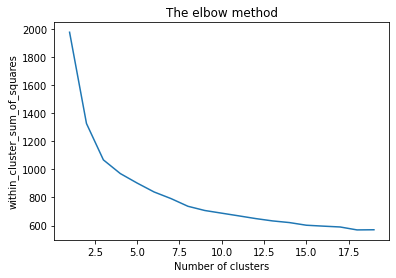

In [79]:

from sklearn.cluster import KMeans
within_cluster_sum_of_squares = []

for i in range(1, 20):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 42)
    kmeans.fit(descriptive_features_normailsed)
    within_cluster_sum_of_squares.append(kmeans.inertia_)
    
#Plotting the results onto a line graph, allowing us to observe 'The elbow'
plt.plot(range(1, 20), within_cluster_sum_of_squares)
plt.title('The elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('within_cluster_sum_of_squares') #within cluster sum of squares
plt.show()


In [80]:

kmeans = KMeans(
        init="random",
        n_clusters=3,
        n_init=10,
        max_iter=300,
        random_state=42
    )
km = kmeans.fit(descriptive_features_normailsed)




In [81]:
already_seen = {}
labels = km.labels_
clusters = []

for i in range(len(event_log)):
        if not labels[i] in already_seen:
            already_seen[labels[i]] = len(list(already_seen.keys()))
            clusters.append(EventLog())
        trace = event_log[i]
        clusters[already_seen[labels[i]]].append(trace)

type(clusters[0]),len(clusters[0]),len(clusters[1]),len(clusters[2])

(pm4py.objects.log.obj.EventLog, 410, 238, 81)

In [82]:
sub_log1 = clusters[0]
sub_log2 = clusters[1]
sub_log3 = clusters[2]

pm4py.write_xes(sub_log1, 'Sublogs-Alpha-Clustering-Normalised/sublog1.xes')
pm4py.write_xes(sub_log2, 'Sublogs-Alpha-Clustering-Normalised/sublog2.xes')
pm4py.write_xes(sub_log3, 'Sublogs-Alpha-Clustering-Normalised/sublog3.xes')


exporting log, completed traces :: 100%|██████████| 81/81 [00:01<00:00, 59.90it/s] 


### Finding Important Feature of K means Clustering

In [83]:
# Wrapper of Random Forest classifier on K means
class Kmeans_Custom_RF(KMeans):
    def __init__(self, ordered_features, method='wcss_min', **kwargs):
        super().__init__(**kwargs)
        self.method = method
        self.ordered_features = ordered_features

    def fit(self, X, y=None, sample_weight=None):
        super().fit(X, y, sample_weight)
        
        if self.method == 'unsup2sup':
            self.important_features = self.get_importance_unsup2sup(X)
        
        elif self.method == 'wcss_min':
            self.important_features = self.get_importance_wcss_min()
        return self

    def get_importance_wcss_min(self):
        labels = self.n_clusters
        centroids = np.abs(self.cluster_centers_)
        sorted_centroid_features_idx = np.argsort(centroids, axis=1)[:,::-1]

        weighted_features = {}
        for label, centroid in enumerate(sorted_centroid_features_idx):
            ordered_weights = centroids[label][centroid]
            ordered_features = [self.ordered_features[feature] for feature in centroid]
            weighted_features[label] = list(zip(ordered_features, ordered_weights))
        
        return weighted_features

    def get_importance_unsup2sup(self, X):

        weighted_features = {}
        for label in range(self.n_clusters):
            binary_encoding = np.array([1 if x == label else 0 for x in self.labels_])
            classifier = RandomForestClassifier()
            classifier.fit(X, binary_encoding)

            sorted_features_idx = np.argsort(classifier.feature_importances_)[::-1]
            ordered_features = np.array(self.ordered_features)[sorted_features_idx]
            ordered_weights = classifier.feature_importances_[sorted_features_idx]
            weighted_features[label] = list(zip(ordered_features, ordered_weights))
        return weighted_features

In [84]:
descriptive_features = descriptive_features.loc[:, descriptive_features.columns != "Unnamed: 0"]

In [106]:
descriptive_features_normailsed

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,0.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.928571,...,1.0,0.000000,0.0,1.0,1.0,0.094444,0.094595,0.101449,0.019608,0.0
1,0.001289,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.357143,...,1.0,0.007299,0.0,1.0,1.0,0.038889,0.013514,0.043478,0.019608,0.0
2,0.002577,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.500000,...,1.0,0.014599,0.0,1.0,1.0,0.050000,0.040541,0.043478,0.000000,0.0
3,0.003866,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.714286,...,1.0,0.021898,0.0,0.0,1.0,0.044444,0.027027,0.028986,0.019608,0.0
4,0.005155,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.428571,...,1.0,0.029197,0.0,0.0,1.0,0.027778,0.013514,0.014493,0.019608,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
724,0.994845,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.142857,...,0.0,0.182482,0.0,0.0,1.0,0.011111,0.013514,0.014493,0.000000,0.0
725,0.996134,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.642857,...,0.0,0.197080,0.0,0.0,0.0,0.066667,0.081081,0.072464,0.000000,0.0
726,0.997423,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.500000,...,1.0,0.043796,0.0,1.0,1.0,0.111111,0.081081,0.072464,0.098039,0.0
727,0.998711,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.785714,...,1.0,0.043796,0.0,1.0,1.0,0.138889,0.108108,0.130435,0.098039,0.0


In [107]:
descriptive_features_normailsed = descriptive_features_normailsed.drop(descriptive_features_normailsed.columns[0], axis=1)


In [108]:
descriptive_features_normailsed

,1,2,3,4,5,6,7,8,9,10,...,20,21,22,23,24,25,26,27,28,29
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.928571,1.0,...,1.0,0.000000,0.0,1.0,1.0,0.094444,0.094595,0.101449,0.019608,0.0
1,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.357143,1.0,...,1.0,0.007299,0.0,1.0,1.0,0.038889,0.013514,0.043478,0.019608,0.0
2,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.500000,1.0,...,1.0,0.014599,0.0,1.0,1.0,0.050000,0.040541,0.043478,0.000000,0.0
3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.714286,1.0,...,1.0,0.021898,0.0,0.0,1.0,0.044444,0.027027,0.028986,0.019608,0.0
4,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.428571,1.0,...,1.0,0.029197,0.0,0.0,1.0,0.027778,0.013514,0.014493,0.019608,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
724,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.142857,1.0,...,0.0,0.182482,0.0,0.0,1.0,0.011111,0.013514,0.014493,0.000000,0.0
725,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.642857,0.0,...,0.0,0.197080,0.0,0.0,0.0,0.066667,0.081081,0.072464,0.000000,0.0
726,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.500000,1.0,...,1.0,0.043796,0.0,1.0,1.0,0.111111,0.081081,0.072464,0.098039,0.0
727,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.785714,1.0,...,1.0,0.043796,0.0,1.0,1.0,0.138889,0.108108,0.130435,0.098039,0.0


In [85]:

kms = Kmeans_Custom_RF(
	n_clusters=3,
	ordered_feature_names=descriptive_features.columns.tolist(), 
	feature_importance_method='wcss_min', # or 'unsup2sup'
).fit(descriptive_features.values)

# A dictionary where the key [0] is the cluster label, and [:10] will refer to the first 10 most important features
kms.feature_importances_[0][:10] # Features here are words


[('Age', 81.1311053984576),
 ('Activity_count', 16.45758354755784),
 ('Diagnose', 8.62724935732647),
 ('Leucocytes_count', 3.6812339331619532),
 ('CRP_count', 3.508997429305912),
 ('LacticAcid_count', 1.4652956298200512),
 ('SIRSCriteria2OrMore', 0.8997429305912596),
 ('InfectionSuspected', 0.8920308483290487),
 ('DiagnosticIC', 0.8868894601542415),
 ('DiagnosticBlood', 0.8637532133676092)]

In [86]:
features_kms = pd.DataFrame(kms.feature_importances_[0][:10])
features_kms.set_index(0,inplace=True)
features_kms


,1
0,
Age,81.131105
Activity_count,16.457584
Diagnose,8.627249
Leucocytes_count,3.681234
CRP_count,3.508997
LacticAcid_count,1.465296
SIRSCriteria2OrMore,0.899743
InfectionSuspected,0.892031
DiagnosticIC,0.886889


(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, 'Age'),
  Text(1, 0, 'Activity_count'),
  Text(2, 0, 'Diagnose'),
  Text(3, 0, 'Leucocytes_count'),
  Text(4, 0, 'CRP_count'),
  Text(5, 0, 'LacticAcid_count'),
  Text(6, 0, 'SIRSCriteria2OrMore'),
  Text(7, 0, 'InfectionSuspected'),
  Text(8, 0, 'DiagnosticIC'),
  Text(9, 0, 'DiagnosticBlood')])

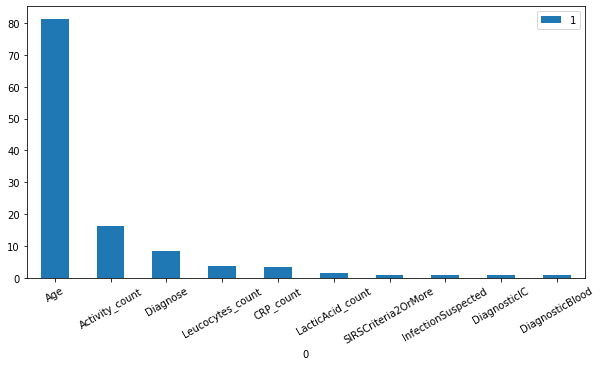

In [87]:
features_kms.plot.bar(figsize=(10,5))
plt.xticks(rotation=30)

In [88]:
descriptive_features

,InfectionSuspected,DiagnosticBlood,DisfuncOrg,SIRSCritTachypnea,Hypotensie,SIRSCritHeartRate,Infusion,DiagnosticArtAstrup,Age,DiagnosticIC,...,DiagnosticLacticAcid,Diagnose,Hypoxie,DiagnosticUrinarySediment,DiagnosticECG,Activity_count,Leucocytes_count,CRP_count,LacticAcid_count,Release_type
0,1,1,1,1,1,1,1,1,85.0,1,...,1,0,0,1,1,22.0,7.0,7.0,1.0,0
1,1,1,0,1,0,1,1,0,45.0,1,...,1,1,0,1,1,12.0,1.0,3.0,1.0,0
2,1,1,0,0,0,1,1,1,55.0,1,...,1,2,0,1,1,14.0,3.0,3.0,0.0,0
3,1,1,0,1,0,1,1,1,70.0,1,...,1,3,0,0,1,13.0,2.0,2.0,1.0,0
4,1,1,0,0,0,1,1,0,50.0,1,...,1,4,0,0,1,10.0,1.0,1.0,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
724,0,0,0,0,0,0,0,1,30.0,1,...,0,25,0,0,1,7.0,1.0,1.0,0.0,0
725,0,0,0,1,0,1,0,0,65.0,0,...,0,27,0,0,0,17.0,6.0,5.0,0.0,0
726,1,1,0,1,0,1,1,0,55.0,1,...,1,6,0,1,1,25.0,6.0,5.0,5.0,0
727,1,1,0,1,0,1,1,1,75.0,1,...,1,6,0,1,1,30.0,8.0,9.0,5.0,0


In [94]:
descriptive_features.shape

(729, 29)

In [90]:
descriptive_features_normailsed.shape

(729, 30)

In [109]:

kms_normalised = Kmeans_Custom_RF(
	n_clusters=3,
	ordered_feature_names=descriptive_features.columns.tolist(), 
	feature_importance_method='wcss_min', # or 'unsup2sup'
).fit(descriptive_features_normailsed.values)

# A dictionary where the key [0] is the cluster label, and [:10] will refer to the first 10 most important features
kms_normalised.feature_importances_[0][:10] 

[('Age', 0.7645502645502645),
 ('Diagnose', 0.29683698296836986),
 ('SIRSCritHeartRate', 0.1604938271604941),
 ('SIRSCritTachypnea', 0.16049382716049382),
 ('SIRSCritTemperature', 0.1234567901234569),
 ('Release_type', 0.08024691358024694),
 ('SIRSCriteria2OrMore', 0.07407407407407363),
 ('Infusion', 0.06172839506172878),
 ('InfectionSuspected', 0.049382716049383046),
 ('Leucocytes_count', 0.04337671004337671)]

Text(0.5, 1.0, 'Relative Importance in Clustering')

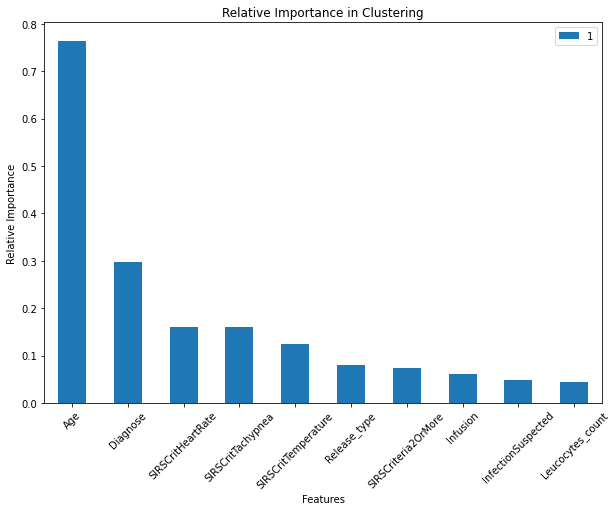

In [126]:
kms_normalised_features = pd.DataFrame(kms_normalised.feature_importances_[0][0:10])
kms_normalised_features.set_index(0,inplace=True)
kms_normalised_features
kms_normalised_features.plot.bar(figsize=(10,7))
plt.xticks(rotation=45)
plt.ylabel("Relative Importance")
plt.xlabel("Features")
plt.title("Relative Importance in Clustering")

## Important Feature - Age 

###  Important Feature - Age 

1. Age - 20-50: 89 Cases
2. 55-65 : 168
3. 70-75 : 181
4. 80-85 : 217
5. 90 : 122

### Important Feature Classification

In [113]:
descriptive_features

,InfectionSuspected,DiagnosticBlood,DisfuncOrg,SIRSCritTachypnea,Hypotensie,SIRSCritHeartRate,Infusion,DiagnosticArtAstrup,Age,DiagnosticIC,...,DiagnosticLacticAcid,Diagnose,Hypoxie,DiagnosticUrinarySediment,DiagnosticECG,Activity_count,Leucocytes_count,CRP_count,LacticAcid_count,Release_type
0,1,1,1,1,1,1,1,1,85.0,1,...,1,0,0,1,1,22.0,7.0,7.0,1.0,0
1,1,1,0,1,0,1,1,0,45.0,1,...,1,1,0,1,1,12.0,1.0,3.0,1.0,0
2,1,1,0,0,0,1,1,1,55.0,1,...,1,2,0,1,1,14.0,3.0,3.0,0.0,0
3,1,1,0,1,0,1,1,1,70.0,1,...,1,3,0,0,1,13.0,2.0,2.0,1.0,0
4,1,1,0,0,0,1,1,0,50.0,1,...,1,4,0,0,1,10.0,1.0,1.0,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
724,0,0,0,0,0,0,0,1,30.0,1,...,0,25,0,0,1,7.0,1.0,1.0,0.0,0
725,0,0,0,1,0,1,0,0,65.0,0,...,0,27,0,0,0,17.0,6.0,5.0,0.0,0
726,1,1,0,1,0,1,1,0,55.0,1,...,1,6,0,1,1,25.0,6.0,5.0,5.0,0
727,1,1,0,1,0,1,1,1,75.0,1,...,1,6,0,1,1,30.0,8.0,9.0,5.0,0


### Target feature = Activity_count

In [114]:
target = descriptive_features['Activity_count']
descriptive = descriptive_features.loc[:, descriptive_features.columns != "Activity_count"]
descriptive = descriptive.loc[:, descriptive.columns != "Unnamed: 0"]

In [122]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
random_forest_classifier = RandomForestClassifier(n_estimators=10, random_state=0)

# fit the model to the training set

random_forest_classifier.fit(descriptive, target)

# Predict on the test set results

y_pred_100 = random_forest_classifier.predict(descriptive)

# Check accuracy score 

print('Model accuracy score with 10 decision-trees : {0:0.4f}'. format(accuracy_score(target, y_pred_100)))

Model accuracy score with 10 decision-trees : 0.9753


In [123]:
# view the feature scores

feature_scores = pd.Series(random_forest_classifier.feature_importances_, index=descriptive.columns).sort_values(ascending=False)
feature_scores

Diagnose                     0.159778
Age                          0.150854
Leucocytes_count             0.150648
CRP_count                    0.128082
LacticAcid_count             0.072258
DiagnosticArtAstrup          0.037576
SIRSCritTachypnea            0.034013
Release_type                 0.031359
DiagnosticUrinaryCulture     0.029049
DiagnosticUrinarySediment    0.026414
SIRSCritTemperature          0.020807
SIRSCritHeartRate            0.020130
Infusion                     0.015338
DiagnosticXthorax            0.015246
DiagnosticECG                0.014635
SIRSCritLeucos               0.011601
DiagnosticLacticAcid         0.010849
Hypotensie                   0.010112
DisfuncOrg                   0.009834
DiagnosticBlood              0.008486
DiagnosticIC                 0.007969
SIRSCriteria2OrMore          0.007832
DiagnosticSputum             0.006768
InfectionSuspected           0.006351
Hypoxie                      0.005409
Oligurie                     0.003321
DiagnosticLi

In [117]:
type(feature_scores)

pandas.core.series.Series

Text(0.5, 1.0, 'Relative Importance in Classification')

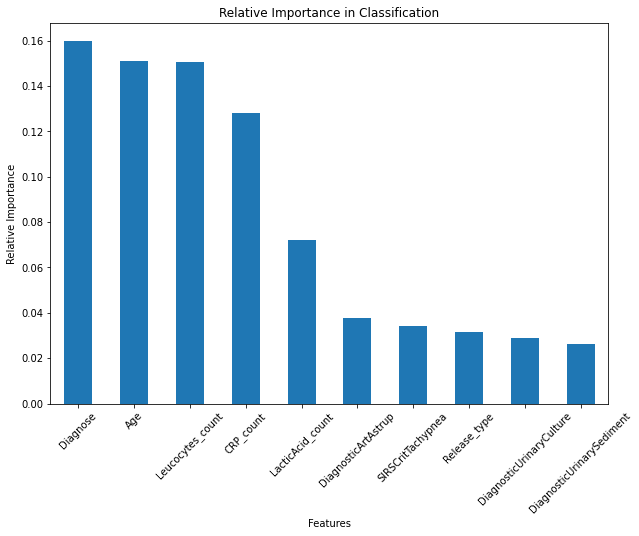

In [127]:

feature_scores.nlargest(10).plot(kind='bar',figsize=(10,7))
plt.xticks(rotation=45)
plt.ylabel("Relative Importance")
plt.xlabel("Features")
plt.title("Relative Importance in Classification")

(array([], dtype=float64), [])

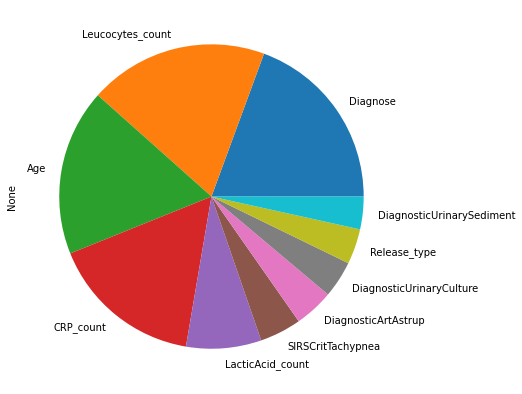

In [96]:
feature_scores.nlargest(10).plot(kind='pie',figsize=(10,7))
plt.xticks(rotation=30)

### Clustering on fitness of sublogs

In [56]:
results = pd.read_excel('results age-10/results age 10.xlsx')
results.head()

,log,model_1,model_2,model_3,model_4,model_5,model_6,model_7,model_8
0,log_1,0.89,0.86,0.85,0.95,0.80,0.96,0.97,0.97
1,log_2,0.76,0.90,0.90,0.96,0.86,0.91,0.93,0.93
2,log_3,0.76,0.87,0.87,0.92,0.84,0.91,0.93,0.93
3,log_4,0.74,0.87,0.87,0.92,0.83,0.92,0.93,0.93
4,log_5,0.74,0.86,0.86,0.91,0.83,0.90,0.92,0.92


In [57]:
data = results.iloc[:, 1:]
data.head()

,model_1,model_2,model_3,model_4,model_5,model_6,model_7,model_8
0,0.89,0.86,0.85,0.95,0.80,0.96,0.97,0.97
1,0.76,0.90,0.90,0.96,0.86,0.91,0.93,0.93
2,0.76,0.87,0.87,0.92,0.84,0.91,0.93,0.93
3,0.74,0.87,0.87,0.92,0.83,0.92,0.93,0.93
4,0.74,0.86,0.86,0.91,0.83,0.90,0.92,0.92


In [58]:
data.values

array([[0.89, 0.86, 0.85, 0.95, 0.8 , 0.96, 0.97, 0.97],
       [0.76, 0.9 , 0.9 , 0.96, 0.86, 0.91, 0.93, 0.93],
       [0.76, 0.87, 0.87, 0.92, 0.84, 0.91, 0.93, 0.93],
       [0.74, 0.87, 0.87, 0.92, 0.83, 0.92, 0.93, 0.93],
       [0.74, 0.86, 0.86, 0.91, 0.83, 0.9 , 0.92, 0.92],
       [0.75, 0.88, 0.88, 0.93, 0.85, 0.93, 0.94, 0.95],
       [0.74, 0.88, 0.88, 0.93, 0.85, 0.93, 0.94, 0.94],
       [0.74, 0.86, 0.86, 0.92, 0.84, 0.92, 0.92, 0.94]])

In [59]:
kmeans = KMeans(
        init="random",
        n_clusters=3,
        n_init=5,
        max_iter=500,
        random_state=42
    )
km = kmeans.fit(data.values)

already_seen = {}
labels = km.labels_
labels



array([2, 0, 1, 1, 1, 0, 0, 1], dtype=int32)

### Clustering on Model Fitness

In [60]:
results = pd.read_excel('results age-10/Results age 10 model.xlsx')
results.head()

,log,log_1,log_2,log_3,log_4,log_5,log_6,log_7,log_8
0,model_1,0.89,0.76,0.76,0.74,0.74,0.75,0.74,0.74
1,model_2,0.86,0.90,0.87,0.87,0.86,0.88,0.88,0.86
2,model_3,0.85,0.90,0.87,0.87,0.86,0.88,0.88,0.86
3,model_4,0.95,0.96,0.92,0.92,0.91,0.93,0.93,0.92
4,model_5,0.80,0.86,0.84,0.83,0.83,0.85,0.85,0.84


In [61]:
data = results.iloc[:, 1:]
data.head()

,log_1,log_2,log_3,log_4,log_5,log_6,log_7,log_8
0,0.89,0.76,0.76,0.74,0.74,0.75,0.74,0.74
1,0.86,0.90,0.87,0.87,0.86,0.88,0.88,0.86
2,0.85,0.90,0.87,0.87,0.86,0.88,0.88,0.86
3,0.95,0.96,0.92,0.92,0.91,0.93,0.93,0.92
4,0.80,0.86,0.84,0.83,0.83,0.85,0.85,0.84


In [62]:
data.values

array([[0.89, 0.76, 0.76, 0.74, 0.74, 0.75, 0.74, 0.74],
       [0.86, 0.9 , 0.87, 0.87, 0.86, 0.88, 0.88, 0.86],
       [0.85, 0.9 , 0.87, 0.87, 0.86, 0.88, 0.88, 0.86],
       [0.95, 0.96, 0.92, 0.92, 0.91, 0.93, 0.93, 0.92],
       [0.8 , 0.86, 0.84, 0.83, 0.83, 0.85, 0.85, 0.84],
       [0.96, 0.91, 0.91, 0.92, 0.9 , 0.93, 0.93, 0.92],
       [0.97, 0.93, 0.93, 0.93, 0.92, 0.94, 0.94, 0.92],
       [0.97, 0.93, 0.93, 0.93, 0.92, 0.95, 0.94, 0.94]])

In [63]:
kmeans = KMeans(
        init="random",
        n_clusters=3,
        n_init=5,
        max_iter=500,
        random_state=42
    )
km = kmeans.fit(data.values)
already_seen = {}
labels = km.labels_
labels

array([2, 0, 0, 1, 0, 1, 1, 1], dtype=int32)

https://medium.com/analytics-vidhya/k-means-algorithm-in-4-parts-4-4-42bc6c781e46


important features 

https://towardsdatascience.com/decision-trees-explained-entropy-information-gain-gini-index-ccp-pruning-4d78070db36c 

Decision Tree

important features on classification of disease or Infection suspected

-------------
Important feature in activities - Release?
Add Release to the columns

https://pure.tue.nl/ws/portalfiles/portal/142431746/MasterThesis_YuxuanZhang_Final.pdf 

Sepsis explained

In [64]:
https://pure.tue.nl/ws/portalfiles/portal/142431746/MasterThesis_YuxuanZhang_Final.pdf

SyntaxError: invalid syntax (1061013701.py, line 1)

“Diagnose” attribute, it has more diverse result.
Noticeable, this “Diagnose” does not necessarily represent the final diagnose result, is neither the
prediction label, but a normal attribute in this case. It shows 145 types of diagnose result

number of events
deal with null values
number of each test - Leucocytes , CRP and lactic acid
